# tinyurl.com/ANLPColab5

## BERT for sentiment analysis

Let's use the pre-trained BERT model from Huggingface to perform sentiment analysis on the IMDB reviews data set (the same one we used for DL models in our last session). We'll access the data set directly through the datasets package in Python.

---



In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from transformers import (BertTokenizerFast,TFBertForSequenceClassification, create_optimizer)
from datasets import load_dataset

Loading the IMDB dataset from huggingface

In [3]:
dataset_id='imdb'
dataset = load_dataset(dataset_id) # load_dataset is a function of datasets library of HuggingFace

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
import pandas as pd
pd.DataFrame({'text':dataset['train'][:5]['text'],'label':dataset['train'][:5]['label']})

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [7]:
#Load the pre-trained tokenizer
model_id="bert-base-uncased" #We'll use the base model (12 layers, 768 hidden units, 12 attention heads, 110M parameters), trained on lowercased text
tokenizer = BertTokenizerFast.from_pretrained(model_id) #Using a pre-trained BERT tokenizer

In [8]:
#Preprocess function which tokenizes, pads, and truncates the text sequences
def preprocess_function(examples):
  return tokenizer(examples["text"],padding=True,truncation=True,)

In [9]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

Creating a data frame for easy inspection and manipulation of the tokenized data - Viewing 5 rows of tokenized data

In [10]:
#create a DataFrame from a dictionary where keys are column names and values are the data for those columns
#tokenized_dataset['train']: Accesses the 'train' split of the tokenized_dataset. [:5]: Selects the first 5 examples from the 'train' split
pd.DataFrame({
    #Extracting different fields
    'text':tokenized_dataset['train'][:5]['text'],
    'label':tokenized_dataset['train'][:5]['label'],
    'input_ids':tokenized_dataset['train'][:5]['input_ids'],
    'token_type_ids':tokenized_dataset['train'][:5]['token_type_ids'],
    'attention_mask':tokenized_dataset['train'][:5]['attention_mask']
    })

,text,label,input_ids,token_type_ids,attention_mask
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,"[101, 1045, 12524, 1045, 2572, 8025, 1011, 375...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,"[101, 1000, 1045, 2572, 8025, 1024, 3756, 1000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,If only to avoid making this type of film in t...,0,"[101, 2065, 2069, 2000, 4468, 2437, 2023, 2828...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,This film was probably inspired by Godard's Ma...,0,"[101, 2023, 2143, 2001, 2763, 4427, 2011, 2643...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"Oh, brother...after hearing about this ridicul...",0,"[101, 2821, 1010, 2567, 1012, 1012, 1012, 2044...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In the next step, we convert our tokenized dataset into TensorFlow datasets for training and validation.

In [11]:
BATCH_SIZE = 8 # Setting batch size to 8 means that during training and validation, the data will be processed in batches of 8 examples at a time

In [12]:
#Create TF datasets from tokenized data
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset( #Accesses the 'train' split of the tokenized_dataset and converts it to a TensorFlow dataset
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'], #Specifies the necessary columns for model input and training
    # Columns include token IDs generated by the tokenizer, token type IDs (used in models like BERT for distinguishing between different segments in a sequence), the attention mask (indicates which tokens should be attended to and which should be ignored), and the labels associated with the text data
    shuffle=True, #Shuffles the dataset to ensure that the training process is not biased by the order of the data
    batch_size=BATCH_SIZE,
)

#Create TF validation dataset
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset( #Accesses the 'test' split of the tokenized_dataset and converts it to a TensorFlow dataset
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

We define a function named swap_positions that takes a single argument dataset and returns a tuple. This structure is required by TensorFlow for supervised learning, where the input features and labels are separated.

In [13]:
#Move label to single dictionary
def swap_positions(dataset):
#A dictionary containing the input_ids, token_type_ids, and attention_mask from the dataset
  return {'input_ids':dataset['input_ids'],
          'token_type_ids':dataset['token_type_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['label']

##Add a prefetching step to the dataset pipeline. Prefetching allows the data to be prepared in the background while the model is training, which can improve training performance
## Autotune automatically tunes the prefetch buffer size for optimal performance
tf_train_dataset=tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset=tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

 The datasets are now ready to be used in a training loop for a machine learning/ deep learning model.Let's apply the transformer!

In [14]:
#Model (As a regression)
model=TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=1)
model.summary() #print model architecture summary

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


*   Model: The name of the model.
*   Layer (type): The name and type of each layer in the model.
*   Output Shape: The shape of the output from each layer.
*  Param #: The number of parameters in each layer.
*   Total params: The total number of parameters in the model.
*   Trainable params: The number of parameters that will be updated during training.
*   Non-trainable params: The number of parameters that will not be updated during training.




Define parameters for the BERT model

In [16]:
#Parameters for the model
num_epochs = 3 #Sets the number of epochs for training as 3. An epoch is one complete pass through the entire training dataset.
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE #Calculates the number of batches per epoch using batch size defined earlier
total_train_steps = int(batches_per_epoch * num_epochs) # Calculates the total number of training steps

# Create an optimizer and a learning rate schedule for training the model
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps) #Sets the initial learning rate, Warmup steps to gradually increase the learning rate at the beginning of training, and the total number of training steps calculated earlier

Let's now compile the model and fit it on our data

In [17]:
# Compile the model with a specified loss function, optimizer, and metrics
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), #Loss function to calculate the cross-entropy loss between true labels and predicted labels
    optimizer=optimizer,
    metrics=['accuracy'],)

In [ ]:
#Model fitting - Train the model using the training and validation datasets.
history=model.fit(
    tf_train_dataset.take(1000), # limits the training to the first 1000 batches of the dataset
    validation_data=tf_val_dataset,
    epochs=3)

Epoch 1/3
1000/1000 [==============================] - 2001s 2s/step - loss: 7.9926 - accuracy: 0.5041 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 2/3
 782/1000 [======================>.......] - ETA: 3:15 - loss: 8.0822 - accuracy: 0.4986

In [ ]:
#Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

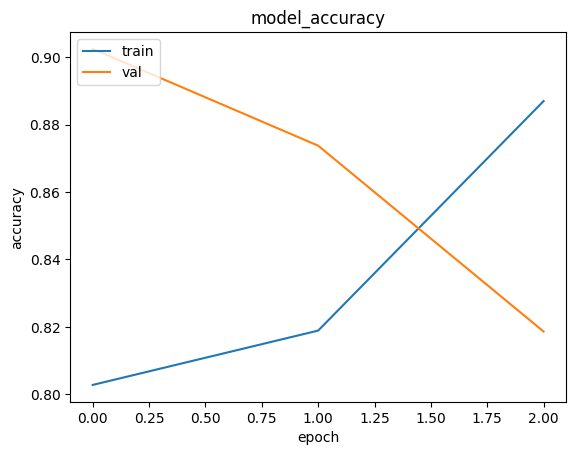

In [ ]:
#Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Save trained BERT model and tokenizer
output_dir = '/content/drive/My Drive/Colab Notebooks/ANLP 2024 Colab Notebooks/Session 5 Colab Notebooks/bert-sentiment-tf'  # Change this to your preferred Google Drive folder path - I've created a folder bert-sentiment-tf to save the model
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/My Drive/bert-sentiment-tf/tokenizer_config.json',
 '/content/drive/My Drive/bert-sentiment-tf/special_tokens_map.json',
 '/content/drive/My Drive/bert-sentiment-tf/vocab.txt',
 '/content/drive/My Drive/bert-sentiment-tf/added_tokens.json',
 '/content/drive/My Drive/bert-sentiment-tf/tokenizer.json')